#Preface

<b>Objective:</b>

Assessing Focus and Comprehension performance in Undistracted and Distracted Reading

<b>Inspiration:</b>

Observing the common practice on TikTok where creators use gameplay videos to maintain user engagement, I wondered if a similar technique could enhance my reading experience. The goal is to determine if incorporating distractions while reading reduces the need for backtracking and improves overall comprehension.

#Data Collection

During the data collection phase, I conducted two trials: one without distractions and one with distractions. Here's a brief overview of the setups:

1. Trial Structure:

  * Each trial consisted of reading the book "Python for Data Science Handbook" for one hour.
  * I took breaks whenever I felt mentally fatigued, indicated by frequently checking the time or finding the need to re-read for comprehension.

2. Data Collection Methods:

  * I utilized the OpenCV library in a Python script to record the instances when I was actively reading and the corresponding timestamps.
  * Additionally, I manually recorded data by taking multiple-choice quizzes on the sections I read in each trial, noting down my scores, and keeping track of the number of pages read.

This combined approach allowed me to gather comprehensive data on both my reading behavior and quiz performance.

#Cleaning Data: Undistracted Reading 


In [ ]:
import pandas as pd

#i naively collected the data, things to fix specified below are also applied to the distracted reading data
undistracted_results = pd.read_csv('/content/friedBrain_df.csv')
print (undistracted_results.head())

   face_detected  eyes_detected   fd_time  ed_time
0              1            NaN  5.950251      NaN
1              0            NaN  5.950251      NaN
2              1            NaN  6.044906      NaN
3              0            NaN  6.044906      NaN
4              1            NaN  6.087430      NaN


Things to fix:
- remove the unnecessary columns
- change fd_time to something more representative
- remove undetected face rows


In [ ]:
#removing unnecessary / unfilled columns
undistracted_results = undistracted_results.drop(columns=['eyes_detected','ed_time'])

#changing fd_time to a more representative name: 
undistracted_results = undistracted_results.rename(columns={'fd_time' : 'detection_time'})

print (undistracted_results.head())
print(len(undistracted_results))

   face_detected  detection_time
0              1        5.950251
1              0        5.950251
2              1        6.044906
3              0        6.044906
4              1        6.087430
35859


In [ ]:
#remove rows with faulty 0's
#i.e rows with fd = 0 and the rows before and after have fd = 1

zeroes_mask = (undistracted_results['face_detected'] == 0) & (undistracted_results['face_detected'].shift(1) == 1) & (undistracted_results['face_detected'].shift(-1) == 1)
undistracted_results = undistracted_results[~zeroes_mask]

pd.set_option('display.max_rows', None)

print(undistracted_results.head())
print(len(undistracted_results))

   face_detected  detection_time
0              1        5.950251
2              1        6.044906
4              1        6.087430
6              1        6.131464
8              1        6.162466
25039


In [ ]:
#remove false undetected rows. Like if I fidgeted, drank water etc.

# Create a new column 'group' to identify 'islands' of 0's and 1's
undistracted_results['group'] = (undistracted_results['face_detected'] != undistracted_results['face_detected'].shift()).cumsum()

# Group the dataframe by 'group' column
groups = undistracted_results.groupby('group')

# Initialize an empty list to store the indices of the rows to be removed
rows_to_remove = []

# Iterate over the groups and identify the groups with <= 50 rows and face_detected = 0
for group_name, group in groups:
    if len(group) <= 50 and group['face_detected'].iloc[0] == 0 and group['face_detected'].iloc[-1] == 0:
        rows_to_remove.extend(group.index)

# Remove the rows from the dataframe
undistracted_results = undistracted_results.drop(rows_to_remove)

# Remove the 'group' column
undistracted_results = undistracted_results.drop('group', axis=1)

In [ ]:
#compare new size to the old size, should be smaller.
print(len(undistracted_results))

20152


#Cleaning Data: Distracted Reading

In [ ]:
import pandas as pd

distracted_results = pd.read_csv('/content/distractedBrain_df.csv')
print(distracted_results.head())

   face_detected  eyes_detected   fd_time  ed_time
0              0            NaN  6.564063      NaN
1              1            NaN  6.672797      NaN
2              0            NaN  6.672797      NaN
3              1            NaN  6.712796      NaN
4              0            NaN  6.712796      NaN


In [ ]:
#removing unnecessary / unfilled columns
distracted_results = distracted_results.drop(columns=['eyes_detected','ed_time'])

#changing fd_time to a more representative name: 
distracted_results = distracted_results.rename(columns={'fd_time' : 'detection_time'})

print (distracted_results.head())
print (len(distracted_results))

   face_detected  detection_time
0              0        6.564063
1              1        6.672797
2              0        6.672797
3              1        6.712796
4              0        6.712796
36201


In [ ]:
zeroes_mask = (distracted_results['face_detected'] == 0) & (distracted_results['face_detected'].shift(1) == 1) & (distracted_results['face_detected'].shift(-1) == 1)

distracted_results = distracted_results[~zeroes_mask]

pd.set_option('display.max_rows', None)

print(distracted_results.head())
print(len(distracted_results))

   face_detected  detection_time
0              0        6.564063
1              1        6.672797
3              1        6.712796
5              1        6.750329
7              1        6.787318
20166


In [ ]:
#remove false undetected rows. Like if I fidgeted, drank water etc.

# WLOG, identify the islands of 0's and 1's and number them just like before, just done in a diff. df
distracted_results['group'] = (distracted_results['face_detected'] != distracted_results['face_detected'].shift()).cumsum()

# Group the dataframe by 'group' column
groups = distracted_results.groupby('group')

# Initialize an empty list to store the indices of the rows to be removed
rows_to_remove = []

# Iterate over the groups and identify the groups with <= 50 rows and face_detected = 0
for group_name, group in groups:
    if len(group) <= 50 and group['face_detected'].iloc[0] == 0 and group['face_detected'].iloc[-1] == 0:
        rows_to_remove.extend(group.index)

# Remove the rows from the dataframe
distracted_results = distracted_results.drop(rows_to_remove)

# Remove the 'group' column
distracted_results = distracted_results.drop('group', axis=1)

In [ ]:
#compare with dataframe that included the false rows, should be smaller
print(len(distracted_results))

18715


#Collecting Data: Break Times

In [ ]:
#getting the lengths of breaks
import pandas as pd

distracted_break_totals_df = pd.DataFrame(columns=['start_time', 'end_time'])
rolling_total_start = None
rolling_total_end = None

# Loop through the dataframe rows
for index, row in distracted_results.iterrows():
    face_detected_value = row['face_detected']
    detection_time = row['detection_time']
    
    #new / first break reached
    if face_detected_value == 0:
        # mark the new break if it hasn't been started yet
        if rolling_total_start is None:
            rolling_total_start = detection_time
    
    #end of break reached
    elif face_detected_value == 1 and rolling_total_start is not None:
        # Record the end time of the break
        rolling_total_end = detection_time
        
        # Create a dictionary object to store the break duration
        rolling_total = {
            'start_time': rolling_total_start,
            'end_time': rolling_total_end
        }
        
        # Append the break as a new row to the distracted_break_totals_df dataframe
        distracted_break_totals_df = distracted_break_totals_df.append(rolling_total, ignore_index=True)
        
        # Reset the duration recording variables for the next break
        rolling_total_start = None
        rolling_total_end = None

# Check if a break is still in progress when reaching the end of the dataframe
if rolling_total_start is not None and rolling_total_end is None:
    rolling_total_end = distracted_results.iloc[-1]['detection_time']
    
    # Create a dictionary object for the last break (if any)
    rolling_total = {
        'start_time': rolling_total_start,
        'end_time': rolling_total_end
    }
    
    # Append the last break as a new row to the distracted_break_totals_df dataframe
    distracted_break_totals_df = distracted_break_totals_df.append(rolling_total, ignore_index=True)


In [ ]:
pd.set_option('display.max_rows',None)

print(distracted_break_totals_df)

    start_time     end_time
0   533.953024   540.832747
1  1690.457583  1887.397205
2  1893.031578  1914.145980
3  3061.942892  3102.837913
4  3102.837913  3187.709035


In [ ]:
#getting the lengths of breaks again

import pandas as pd

focused_break_totals_df = pd.DataFrame(columns=['start_time', 'end_time'])
rolling_total_start = None
rolling_total_end = None

# Loop through the dataframe rows
for index, row in undistracted_results.iterrows():
    face_detected_value = row['face_detected']
    detection_time = row['detection_time']
    
    #new / first break detected
    if face_detected_value == 0:
        # Start a new break if it hasn't been started yet
        if rolling_total_start is None:
            rolling_total_start = detection_time
    
    #end of break detected
    elif face_detected_value == 1 and rolling_total_start is not None:
        # Record the end time of the break
        rolling_total_end = detection_time
        
        # Create a dictionary object to store the break information
        rolling_total = {
            'start_time': rolling_total_start,
            'end_time': rolling_total_end
        }
        
        # Append the break as a new row to the focused_break_totals_df dataframe
        focused_break_totals_df = focused_break_totals_df.append(rolling_total, ignore_index=True)
        
        # Reset the duration variables for the next break
        rolling_total_start = None
        rolling_total_end = None

# Check if a break is still in progress when reaching the end of the dataframe
if rolling_total_start is not None and rolling_total_end is None:
    rolling_total_end = undistracted_results.iloc[-1]['detection_time']
    
    # Create a dictionary object for the last break
    rolling_total = {
        'start_time': rolling_total_start,
        'end_time': rolling_total_end
    }
    
    # Append the last break as a new row to the focused_break_totals_df dataframe
    focused_break_totals_df = focused_break_totals_df.append(rolling_total, ignore_index=True)


In [ ]:
pd.set_option('display.max_rows',None)

print(focused_break_totals_df)

     start_time     end_time
0    374.714268   380.213569
1    715.978380  1029.483127
2   1082.306152  1093.199547
3   1287.990566  1299.750772
4   1300.466727  1312.539657
5   1445.305624  1455.513844
6   1459.340274  1475.678607
7   1532.375868  1544.797261
8   1589.467890  1600.882084
9   1608.003502  1617.187495
10  1625.956194  1665.632416
11  1666.984272  1689.494312
12  1691.702991  1716.467405
13  1726.240882  1734.867143
14  1781.930121  1799.349401
15  1809.884274  1841.516077
16  1847.763920  1866.384019
17  1881.431670  1898.691217
18  1900.309237  1912.516387
19  2054.174804  2116.202737
20  2116.202737  2126.294255
21  2128.215136  2293.481482
22  2558.977350  2568.169221
23  3097.207289  3210.007295
24  3210.479966  3304.252968
25  3550.495910  3600.014897


#Collecting Data: Quiz Scores

In [ ]:
focused_quiz_scores = pd.DataFrame(columns=['quiz', 'score'])

# Insert the quiz names and scores into the DataFrame
focused_quiz_scores = focused_quiz_scores.append({'quiz': 'Simple Line Plots', 'score': '9/11'}, ignore_index=True)
focused_quiz_scores = focused_quiz_scores.append({'quiz': 'Plotting basics', 'score': '4/11'}, ignore_index=True)
focused_quiz_scores = focused_quiz_scores.append({'quiz': 'Visualising errors', 'score': '3/6'}, ignore_index=True)
focused_quiz_scores = focused_quiz_scores.append({'quiz': 'Density and contour plots', 'score': '8/8'}, ignore_index=True)
focused_quiz_scores = focused_quiz_scores.append({'quiz': 'Histograms, binnings', 'score': '8/10'}, ignore_index=True)
focused_quiz_scores = focused_quiz_scores.append({'quiz': 'Customizing plot legends', 'score': '7/10'}, ignore_index=True)



In [ ]:
#change scores into percentages
focused_quiz_scores['score'] = focused_quiz_scores['score'].apply(lambda x: round(eval(x) * 100, 2))

# Print the updated DataFrame
print(focused_quiz_scores)

                        quiz   score
0          Simple Line Plots   81.82
1            Plotting basics   36.36
2         Visualising errors   50.00
3  Density and contour plots  100.00
4       Histograms, binnings   80.00
5   Customizing plot legends   70.00


In [ ]:
# Create the 'distracted_quiz_scores' DataFrame
distracted_quiz_scores = pd.DataFrame(columns=['quiz', 'score'])

# Insert the quiz names and scores into the DataFrame
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Customizing colarbars', 'score': '6/9'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Multiple subplots', 'score': '7/10'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Text and annotation', 'score': '5/6'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Customizing ticks', 'score': '7/10'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Matplotlib', 'score': '8/10'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': '3D plotting', 'score': '8/10'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Geographic data', 'score': '6/10'}, ignore_index=True)
distracted_quiz_scores = distracted_quiz_scores.append({'quiz': 'Visualization with seaborn', 'score': '7/10'}, ignore_index=True)


In [ ]:
# change scores to percentages
distracted_quiz_scores['score'] = distracted_quiz_scores['score'].apply(lambda x: round(eval(x) * 100, 2))

# Print the updated DataFrame
print(distracted_quiz_scores)

                         quiz  score
0       Customizing colarbars  66.67
1           Multiple subplots  70.00
2         Text and annotation  83.33
3           Customizing ticks  70.00
4                  Matplotlib  80.00
5                 3D plotting  80.00
6             Geographic data  60.00
7  Visualization with seaborn  70.00


In [ ]:
# Merge the DataFrames
merged_scores = pd.concat([distracted_quiz_scores, focused_quiz_scores], keys=['distracted', 'focused'])

# add origin of each score as a column in df
merged_scores = merged_scores.reset_index()
merged_scores = merged_scores.rename(columns={'level_0': 'origin'})

# Remove the 'level_1' column (indices of rows in their original dataframes)
merged_scores = merged_scores.drop(columns='level_1')

# Display the merged DataFrame
print(merged_scores)

        origin                        quiz   score
0   distracted       Customizing colarbars   66.67
1   distracted           Multiple subplots   70.00
2   distracted         Text and annotation   83.33
3   distracted           Customizing ticks   70.00
4   distracted                  Matplotlib   80.00
5   distracted                 3D plotting   80.00
6   distracted             Geographic data   60.00
7   distracted  Visualization with seaborn   70.00
8      focused           Simple Line Plots   81.82
9      focused             Plotting basics   36.36
10     focused          Visualising errors   50.00
11     focused   Density and contour plots  100.00
12     focused        Histograms, binnings   80.00
13     focused    Customizing plot legends   70.00


#Collecting Data: Reading times


In [ ]:
#apply same logic in collecting break time durations to collect distracted_reading times

distracted_reading_totals_df = pd.DataFrame(columns=['start_time', 'end_time'])
rolling_total_start = None
rolling_total_end = None

# Loop through the dataframe rows
for index, row in distracted_results.iterrows():
    face_detected_value = row['face_detected']
    detection_time = row['detection_time']
    
    if face_detected_value == 1:
        # Start a new rolling total if it hasn't been started yet
        if rolling_total_start is None:
            rolling_total_start = detection_time
        
        # Update the end time of the rolling total
        rolling_total_end = detection_time
    
    elif face_detected_value == 0 and rolling_total_start is not None:
        # Create a dictionary object to store the rolling total information
        rolling_total = {
            'start_time': rolling_total_start,
            'end_time': rolling_total_end
        }
        
        # Append the rolling total as a new row to the distracted_reading_totals_df dataframe
        distracted_reading_totals_df = distracted_reading_totals_df.append(rolling_total, ignore_index=True)
        
        # Reset the rolling total variables for the next rolling total
        rolling_total_start = None
        rolling_total_end = None

# Check if a rolling total is still in progress when reaching the end of the dataframe
if rolling_total_start is not None and rolling_total_end is None:
    rolling_total_end = distracted_results.iloc[-1]['detection_time']
    
    # Create a dictionary object for the last rolling total
    rolling_total = {
        'start_time': rolling_total_start,
        'end_time': rolling_total_end
    }
    
    # Append the last rolling total as a new row to the distracted_reading_totals_df dataframe
    distracted_reading_totals_df = distracted_reading_totals_df.append(rolling_total, ignore_index=True)


In [ ]:
#error in initial collection,record last reading duration
distracted_reading_totals_df = distracted_reading_totals_df.append({
    'start_time': 3187.709035,
    'end_time': 3600.098200
},ignore_index = True)

In [ ]:
pd.set_option('display.max_rows', None)
print(distracted_reading_totals_df)


    start_time     end_time
0     6.672797   533.953024
1   540.832747  1690.457583
2  1887.397205  1893.031578
3  1914.145980  3061.942892
4  3102.837913  3102.837913
5  3187.709035  3600.098200


In [ ]:
#apply same logic in collecting break time durations to collect focused reading times

import pandas as pd

focused_reading_totals_df = pd.DataFrame(columns=['start_time', 'end_time'])
rolling_total_start = None
rolling_total_end = None

# Loop through the dataframe rows
for index, row in undistracted_results.iterrows():
    face_detected_value = row['face_detected']
    detection_time = row['detection_time']
    
    if face_detected_value == 1:
        # Start a new rolling total if it hasn't been started yet
        if rolling_total_start is None:
            rolling_total_start = detection_time
    
    elif face_detected_value == 0 and rolling_total_start is not None:
        # Record the end time of the rolling total
        rolling_total_end = detection_time
        
        # Create a dictionary object to store the rolling total information
        rolling_total = {
            'start_time': rolling_total_start,
            'end_time': rolling_total_end
        }
        
        # Append the rolling total as a new row to the focused_reading_totals_df dataframe
        focused_reading_totals_df = focused_reading_totals_df.append(rolling_total, ignore_index=True)
        
        # Reset the rolling total variables for the next rolling total
        rolling_total_start = None
        rolling_total_end = None

# Check if a rolling total is still in progress when reaching the end of the dataframe
if rolling_total_start is not None and rolling_total_end is None:
    rolling_total_end = undistracted_results.iloc[-1]['detection_time']
    
    # Create a dictionary object for the last rolling total
    rolling_total = {
        'start_time': rolling_total_start,
        'end_time': rolling_total_end
    }
    
    # Append the last rolling total as a new row to the focused_reading_totals_df dataframe
    focused_reading_totals_df = focused_reading_totals_df.append(rolling_total, ignore_index=True)


In [ ]:
pd.set_option('display.max_rows', None)
print(focused_reading_totals_df)

     start_time     end_time
0      5.950251   374.714268
1    380.213569   715.978380
2   1029.483127  1082.306152
3   1093.199547  1287.990566
4   1299.750772  1300.466727
5   1312.539657  1445.305624
6   1455.513844  1459.340274
7   1475.678607  1532.375868
8   1544.797261  1589.467890
9   1600.882084  1608.003502
10  1617.187495  1625.956194
11  1665.632416  1666.984272
12  1689.494312  1691.702991
13  1716.467405  1726.240882
14  1734.867143  1781.930121
15  1799.349401  1809.884274
16  1841.516077  1847.763920
17  1866.384019  1881.431670
18  1898.691217  1900.309237
19  1912.516387  2054.174804
20  2116.202737  2116.202737
21  2126.294255  2128.215136
22  2293.481482  2558.977350
23  2568.169221  3097.207289
24  3210.007295  3210.479966
25  3304.252968  3550.495910


#Cleaning Data: Reading Times


In [ ]:
#remove reading durations that arent significant (usually less than a minute or so)

distracted_reading_totals_df = distracted_reading_totals_df.drop(4)
distracted_reading_totals_df = distracted_reading_totals_df.drop(2)

print(distracted_reading_totals_df)

    start_time     end_time
0     6.672797   533.953024
1   540.832747  1690.457583
3  1914.145980  3061.942892
4  3102.837913  3102.837913
5  3187.709035  3600.098200


In [ ]:
faulty_recordings=[4,6,9,10,11,12,13,15,16,18,20,21,24]
focused_reading_totals_df = focused_reading_totals_df.drop(faulty_recordings, axis=0)
print(focused_reading_totals_df)

     start_time     end_time
0      5.950251   374.714268
1    380.213569   715.978380
2   1029.483127  1082.306152
3   1093.199547  1287.990566
5   1312.539657  1445.305624
7   1475.678607  1532.375868
8   1544.797261  1589.467890
14  1734.867143  1781.930121
17  1866.384019  1881.431670
19  1912.516387  2054.174804
22  2293.481482  2558.977350
23  2568.169221  3097.207289
25  3304.252968  3550.495910


#Exploratory Analysis: Reading & Break Times
-- --
Mean, Median, Standard Deviation

In [ ]:
#NOTE: 'm m s' = 'mean median standard deviation'

#m m s of distracted reading

# Calculate the duration of each reading period
distracted_reading_totals_df['duration'] = distracted_reading_totals_df['end_time'] - distracted_reading_totals_df['start_time']

# Calculate the m m s for reading time
mean_reading_time = distracted_reading_totals_df['duration'].mean()
median_reading_time = median_age = distracted_reading_totals_df['duration'].median()
std_reading_time = distracted_reading_totals_df['duration'].std()
# Print the result
print("Mean reading time (distracted):", mean_reading_time)
print("Median reading time (distracted):", median_reading_time)
print("Standard Deviation reading time (distracted):", std_reading_time)

Mean reading time (distracted): 647.4182280691223
Median reading time (distracted): 527.2802264690399
Standard Deviation reading time (distracted): 497.8484877988015


In [ ]:
#m m s of focused reading

# Calculate the duration of each reading period
focused_reading_totals_df['duration'] = focused_reading_totals_df['end_time'] - focused_reading_totals_df['start_time']

# Calculate the m m s for reading time
fo_mean_reading_time = focused_reading_totals_df['duration'].mean()
fo_median_reading_time = median_age = focused_reading_totals_df['duration'].median()
fo_std_reading_time = focused_reading_totals_df['duration'].std()
# Print the result
print("Mean reading time (focused):", fo_mean_reading_time)
print("Median reading time (focused):", fo_median_reading_time)
print("Standard Deviation reading time (focused):", fo_std_reading_time)

Mean reading time (focused): 186.98635794566223
Median reading time (focused): 141.65841698646568
Standard Deviation reading time (focused): 155.79855460147797


In [ ]:
# m m s of distracted breaks

# Calculate the duration of each reading period
distracted_break_totals_df['duration'] = distracted_break_totals_df['end_time'] - distracted_break_totals_df['start_time']

# Calculate the m m s of break time
mean_break_time = distracted_break_totals_df['duration'].mean()
median_break_time = median_age = distracted_break_totals_df['duration'].median()
std_break_time = distracted_break_totals_df['duration'].std()
# Print the result
print("Mean break time (distracted):", mean_break_time)
print("Median break time (distracted):", median_break_time)
print("Standard Deviation break time (distracted):", std_break_time)

Mean break time (distracted): 70.13997774124145
Median break time (distracted): 40.895020723342896
Standard Deviation break time (distracted): 76.73947923397375


In [ ]:
# Calculate the duration of each reading period
focused_break_totals_df['duration'] = focused_break_totals_df['end_time'] - focused_break_totals_df['start_time']

# Calculate the m m s of break time
fo_mean_break_time = focused_break_totals_df['duration'].mean()
fo_median_break_time = median_age = focused_break_totals_df['duration'].median()
fo_std_break_time = focused_break_totals_df['duration'].std()
# Print the result
print("Mean break time (focused):", fo_mean_break_time)
print("Median break time (focused):", fo_median_break_time)
print("Standard Deviation break time (focused):", fo_std_break_time)

Mean break time (focused): 42.641584203793464
Median break time (focused): 16.798939704895133
Standard Deviation break time (focused): 67.04167546228894


#Exploratory Analysis: Quiz Scores
-- --
Mean, Median, Standard Deviation

In [ ]:
# Calculate the mean of the 'score' column
mean_score = distracted_quiz_scores['score'].mean()

# Calculate the median of the 'score' column
median_score = distracted_quiz_scores['score'].median()

# Calculate the standard deviation of the 'score' column
std_score = distracted_quiz_scores['score'].std()

# Print the mean, median, and standard deviation
print("Mean score:", mean_score)
print("Median score:", median_score)
print("Standard Deviation of score:", std_score)

Mean score: 72.5
Median score: 70.0
Standard Deviation of score: 7.917230756845656


In [ ]:


# Prefix each score with 'fo_'
focused_quiz_scores['score'] = focused_quiz_scores['score']

# Calculate the mean of the 'score' column
fo_mean_score = focused_quiz_scores['score'].mean()

# Calculate the median of the 'score' column
fo_median_score = focused_quiz_scores['score'].median()

# Calculate the standard deviation of the 'score' column
fo_std_score = focused_quiz_scores['score'].std()

# Print the mean, median, and standard deviation
print("Mean score:", fo_mean_score)
print("Median score:", fo_median_score)
print("Standard Deviation of score:", fo_std_score)


Mean score: 69.69666666666667
Median score: 75.0
Standard Deviation of score: 23.111944675138584


#Exploratory Analysis: Visualizations

In [ ]:
# Calculate the sum of the 'duration' columns
focused_reading_sum = focused_reading_totals_df['duration'].sum()
distracted_reading_sum = distracted_reading_totals_df['duration'].sum()
focused_break_sum = focused_break_totals_df['duration'].sum()
distracted_break_sum = distracted_break_totals_df['duration'].sum()

# Create a new dataframe
data = {
    'trial': ['focused', 'distracted', 'focused', 'distracted'],
    'cum_sum': [focused_reading_sum, distracted_reading_sum, focused_break_sum, distracted_break_sum],
    'activity': ['reading', 'reading', 'break', 'break']
}
merged_totals_df = pd.DataFrame(data)

# Display the merged_totals_df dataframe
print(merged_totals_df)

        trial      cum_sum activity
0     focused  2430.822653  reading
1  distracted  3237.091140  reading
2     focused  1108.681189    break
3  distracted   350.699889    break


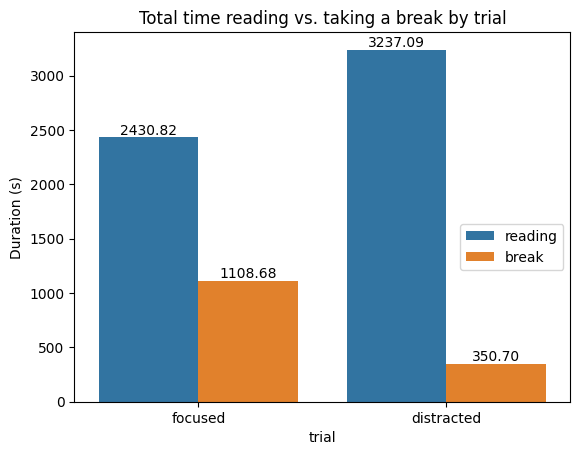

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x='trial',y='cum_sum',hue='activity',data=merged_totals_df)

plt.title('Total time reading vs. taking a break by trial')
plt.xlabel('trial')
plt.ylabel('Duration (s)')
plt.legend(bbox_to_anchor=(1, 0.5))

#annotate the cumulative sums above their corresponding bar
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.show()

In [ ]:
print(distracted_reading_totals_df)

    start_time     end_time     duration
0     6.672797   533.953024   527.280226
1   540.832747  1690.457583  1149.624837
3  1914.145980  3061.942892  1147.796912
4  3102.837913  3102.837913     0.000000
5  3187.709035  3600.098200   412.389165


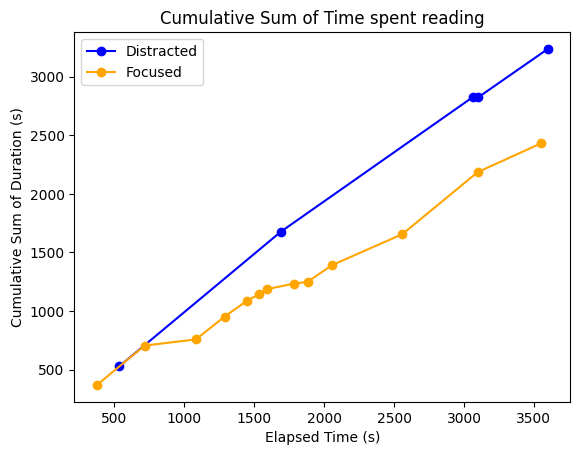

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the cumulative sum of duration for each trial
cumulative_sum_distracted = distracted_reading_totals_df['duration'].cumsum()
cumulative_sum_focused = focused_reading_totals_df['duration'].cumsum()

# Set the x-coordinates as the 'end_time' column for each trial

x_distracted = distracted_reading_totals_df['end_time']
x_focused = focused_reading_totals_df['end_time']

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the points and connect them with a line
ax.plot(x_distracted, cumulative_sum_distracted, marker='o', linestyle='-', label='Distracted', color='blue')
ax.plot(x_focused, cumulative_sum_focused, marker='o', linestyle='-', label='Focused', color='orange')

# Set the plot title and axis labels
plt.title('Cumulative Sum of Time spent reading')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Cumulative Sum of Duration (s)')

# Show the legend
plt.legend()

# Show the plot
plt.show()

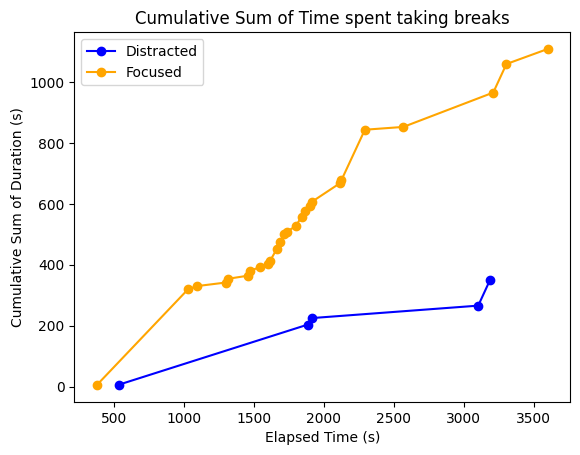

In [ ]:
# Calculate the cumulative sum of duration for each dataframe
cumulative_sum_distracted = distracted_break_totals_df['duration'].cumsum()
cumulative_sum_focused = focused_break_totals_df['duration'].cumsum()

# Set the x-coordinates as the 'end_time' column for each dataframe
x_distracted = distracted_break_totals_df['end_time']
x_focused = focused_break_totals_df['end_time']

# Create the figure and axis objects
fig, ax = plt.subplots()

# Plot the points and connect them with a line
ax.plot(x_distracted, cumulative_sum_distracted, marker='o', linestyle='-', label='Distracted', color='blue')
ax.plot(x_focused, cumulative_sum_focused, marker='o', linestyle='-', label='Focused', color='orange')

# Set the plot title and axis labels
plt.title('Cumulative Sum of Time spent taking breaks')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Cumulative Sum of Duration (s)')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create an empty dataframe to store the merged data
merged_df = pd.DataFrame()

# Concatenate the 'duration' column from each dataframe
dataframes = [focused_reading_totals_df, distracted_reading_totals_df, focused_break_totals_df, distracted_break_totals_df]
origins = ['focused_reading', 'distracted_reading', 'focused_break', 'distracted_break']

#Iterate over DataFrames and origins, adding 'origin' column to each DataFrame and merging them into one df
for df, origin in zip(dataframes, origins):
    df['origin'] = origin
    merged_df = pd.concat([merged_df, df[['duration', 'origin']]], ignore_index=True) 

# Display the merged dataframe
print(merged_df)

       duration              origin
0    368.764017     focused_reading
1    335.764811     focused_reading
2     52.823025     focused_reading
3    194.791019     focused_reading
4    132.765968     focused_reading
5     56.697262     focused_reading
6     44.670630     focused_reading
7     47.062978     focused_reading
8     15.047651     focused_reading
9    141.658417     focused_reading
10   265.495867     focused_reading
11   529.038068     focused_reading
12   246.242942     focused_reading
13   527.280226  distracted_reading
14  1149.624837  distracted_reading
15  1147.796912  distracted_reading
16     0.000000  distracted_reading
17   412.389165  distracted_reading
18     5.499301       focused_break
19   313.504747       focused_break
20    10.893395       focused_break
21    11.760206       focused_break
22    12.072930       focused_break
23    10.208220       focused_break
24    16.338332       focused_break
25    12.421392       focused_break
26    11.414194       focuse

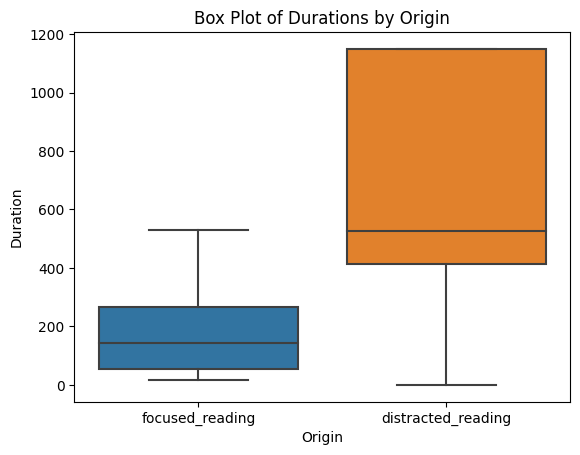

In [ ]:

# Filter the data for the two categories
filtered_data = merged_df[merged_df['origin'].isin(['distracted_reading', 'focused_reading'])]

# Box plot
sns.boxplot(x='origin', y='duration', data=filtered_data)

# Set the x-axis label
plt.xlabel('Origin')

# Set the y-axis label
plt.ylabel('Duration')

# Set the title
plt.title('Box Plot of Durations by Origin')

# Display the plot
plt.show()



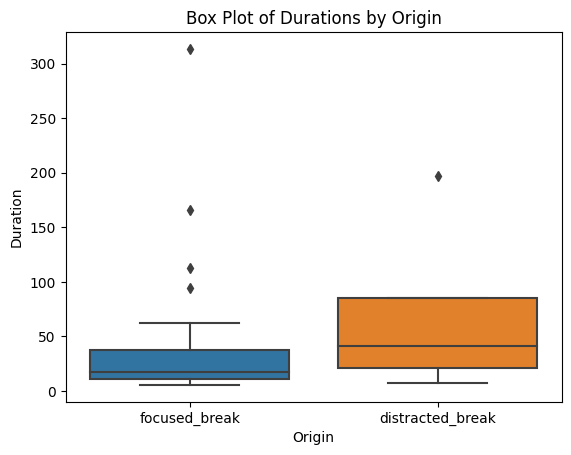

In [ ]:


# Filter the data for the two categories
filtered_data_2 = merged_df[merged_df['origin'].isin(['distracted_break', 'focused_break'])]

# Box plot
sns.boxplot(x='origin', y='duration', data=filtered_data_2)

# Set the x-axis label
plt.xlabel('Origin')

# Set the y-axis label
plt.ylabel('Duration')

# Set the title
plt.title('Box Plot of Durations by Origin')

# Display the plot
plt.show()


#Comparison Analysis

T-tests on reading times: T-stat = 3, p-val = 0.007
* Significant difference, unlikely due to chance

T-test on break times: T-stat = 0.82, p-val = 0.42
* null hypothesis stands, likely due to chance

T-test on quiz scores: T-stat = 0.32, p-val = 0.76
* null hypothesis stands, likely due to chance

In [ ]:
#T-test on average reading times

from scipy.stats import ttest_ind

# Filter the DataFrame based on origin
distracted = merged_df[merged_df['origin'] == 'distracted_reading']['duration']
undistracted = merged_df[merged_df['origin'] == 'focused_reading']['duration']

# Perform t-test
t_statistic, p_value = ttest_ind(distracted, undistracted)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 3.090187374852886
P-value: 0.00702272787776657


In [ ]:
#T-test on average break times

# Filter the DataFrame based on origin
distracted = merged_df[merged_df['origin'] == 'distracted_break']['duration']
undistracted = merged_df[merged_df['origin'] == 'focused_break']['duration']

# Perform t-test
t_statistic, p_value = ttest_ind(distracted, undistracted)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.8225356958519947
P-value: 0.41748435958251706


In [ ]:
#T-test on quiz scores

# Filter the DataFrame based on origin
distracted = merged_scores[merged_scores['origin'] == 'distracted']['score']
undistracted = merged_scores[merged_scores['origin'] == 'focused']['score']

# Perform t-test
t_statistic, p_value = ttest_ind(distracted, undistracted)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.3224560708246787
P-value: 0.752655921971076


#Conclusion : Findings

1. Reading Time and Breaks:

  * Reading with the subway-surfer method resulted in a 33% increase in reading time and a 68% decrease in break time compared to undistracted reading.
  * Statistical analysis (t-test) indicated a significant difference in reading times (t-stat: 3, p-value: 0.007) but no significant difference in break times (t-stat: 0.8, p-value: 0.4).

2. Test Scores:

  * Test scores with the subway-surfer method were higher and more consistent than with undistracted reading.
  * Subway-surfer method: Mean score of 72.5 with a standard deviation of 7.9.
  * Undistracted method: Mean score of 69.69 with a standard deviation of 23.1.
  * Correlation analysis showed no significant difference in test scores (t-stat: 0.32, p-value: 0.75).

3. Pages Read:

  * While reading undistracted, I read 30 pages, compared to 74 pages when reading distracted.
  * It's important to note that the pages read were not solely blocks of text, but specific sections were selected to compare the text-density of each trial (Undistracted: pgs. 224-254, Distracted: pgs. 254-329, from 'Python Data Science Handbook' by Jake VanderPlas).

These findings demonstrate the impact of the subway-surfer method on reading time, breaks, test scores, and the difference in pages read. While the method resulted in increased reading time and reduced break time, test scores showed no significant difference. 

# Conclusion: Insights & Implications

**Insights**

1. Increased Reading Time: The subway-surfer method exhibited significantly longer reading durations compared to undistracted reading (t-stat: 3, p-value: 0.007), indicating its potential to enhance reading duration.
2. Break-Time Correlation: Correlation analysis showed no significant difference in break times between the methods, suggesting similar effects on break durations.
3. Test Score Performance: The subway-surfer method resulted in higher and more consistent test scores than reading undistracted. However, further data is needed to validate the correlation.

**Implications**

1. Improved Reading Performance: Implementing the subway-surfer method can potentially enhance reading performance, allowing for the coverage of more material and achieving higher test scores.
2. Distraction Management: The trial results indicate that the subway-surfer method requires significantly less cumulative break time. Additionally, the duration of breaks did not significantly differ between the methods, suggesting that readers can take breaks as needed without altering their duration.

These insights and implications highlight the advantages of the subway-surfer method in terms of reading duration, test score performance, and break management, offering potential benefits for individuals seeking to optimize their reading experience.

# Recommendations and Future Steps

<b>Recommendations</b>

* Subway-Surfer Method: For readings lasting approximately an hour, consider using the Subway-Surfer method, which showed improved retention of material compared to undistracted reading within this duration.
* TikTok-inspired Approach: If feasible, experiment with replicating the TikTok method by overlaying snippets of text on gameplay footage and utilizing text-to-speech technology to read the text as it appears on the screen.

<b>Future Steps</b>

* Explore Different Distraction Types: Extend the analysis to include other types of distractions such as music or fidgeting in combination with visual distractions. This may provide further insights into their impact on reading performance.
* Long-Term Performance Assessment: Expand the analysis to longer reading sessions, beyond the one-hour trials conducted in this study. Assessing performance over an extended duration will provide valuable information for individuals who engage in lengthier reading sessions.

These recommendations and future steps aim to build upon the findings of this analysis and offer potential avenues for enhancing reading performance and understanding the effects of various distractions.